In [ ]:
# Parsing dei .txt (retrieval correctness)
from pathlib import Path
PREDS_DIR = Path("test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds")

r1_correct = {}
for txt_file in PREDS_DIR.glob("*.txt"):
    with open(txt_file) as f:
        lines = [l.strip() for l in f if l.strip()]

    # estrai sezioni
    pred_idx = lines.index("Predictions paths:") + 1
    pos_idx = lines.index("Positives paths:") + 1

    predictions = []
    for l in lines[pred_idx:]:
        if l.startswith("data/") is False:
            break
        predictions.append(l)

    positives = lines[pos_idx:]

    top1 = predictions[0]
    r1_correct[txt_file.stem] = top1 in positives

print(r1_correct)

Reading predictions from test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/289.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/504.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/262.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/276.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/510.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/538.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/060.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/706.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/712.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/074.txt...
Processing test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds/048.txt...
Processing test_logs/l

In [2]:
# Leggere gli inliers dal matching (TOP-1)
import torch

INLIERS_DIR = Path("logs/netvlad_vgg16_svox_night/2026-01-20_11-56-13/preds_loftr")

inliers_correct = []
inliers_wrong = []

for torch_file in INLIERS_DIR.glob("*.torch"):
    qid = torch_file.stem
    if qid not in r1_correct:
        continue

    results = torch.load(torch_file, map_location="cpu", weights_only=False)

    if len(results) == 0:
        n_inliers = 0
    else:
        n_inliers = results[0]["num_inliers"]

    if r1_correct[qid]:
        inliers_correct.append(n_inliers)
    else:
        inliers_wrong.append(n_inliers)

print(inliers_correct)

[]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


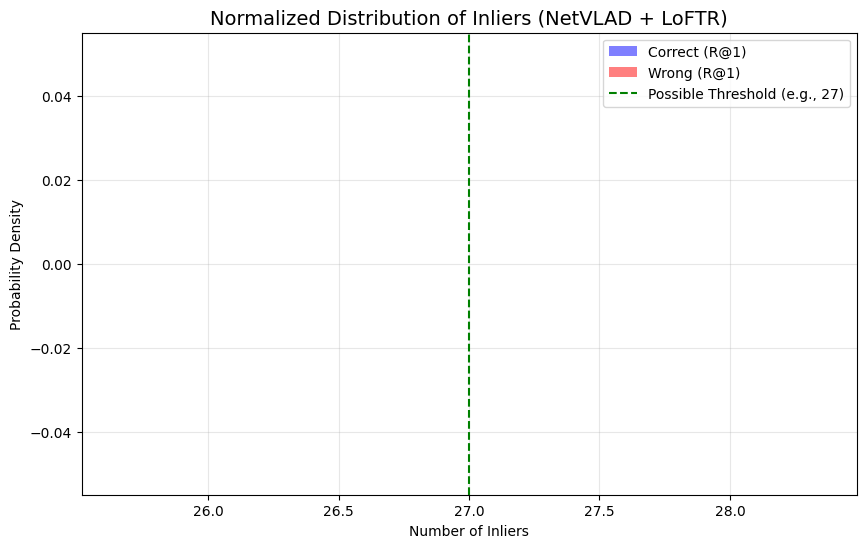

In [3]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))

# density=True è la chiave: normalizza l'area a 1
plt.hist(inliers_correct, bins=30, alpha=0.5, label='Correct (R@1)', color='blue', density=True)
plt.hist(inliers_wrong, bins=10, alpha=0.5, label='Wrong (R@1)', color='red', density=True)

plt.title('Normalized Distribution of Inliers (NetVLAD + LoFTR)', fontsize=14)
plt.xlabel('Number of Inliers')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)

# (es. a occhio sembra che sotto i 15 inliers siano tutti sbagliati)
plt.axvline(x=27, color='green', linestyle='--', label='Possible Threshold (e.g., 27)')
plt.legend()

plt.show()

/var/folders/5t/1tj_701j4vsb2h9h3491lxzc0000gn/T/ipykernel_7408/3597358238.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


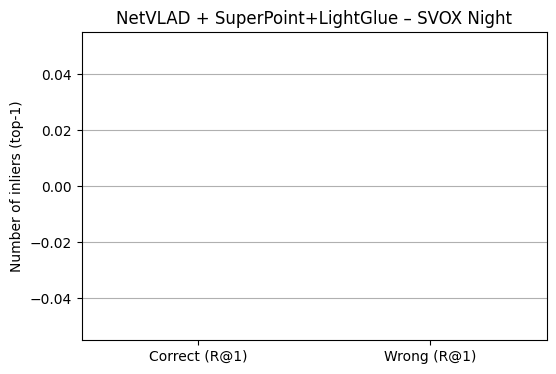

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.boxplot(
    [inliers_correct, inliers_wrong],
    labels=["Correct (R@1)", "Wrong (R@1)"],
    showfliers=True
)

plt.ylabel("Number of inliers (top-1)")
plt.title("NetVLAD + SuperPoint+LightGlue – SVOX Night")
plt.grid(True, axis="y")
plt.show()

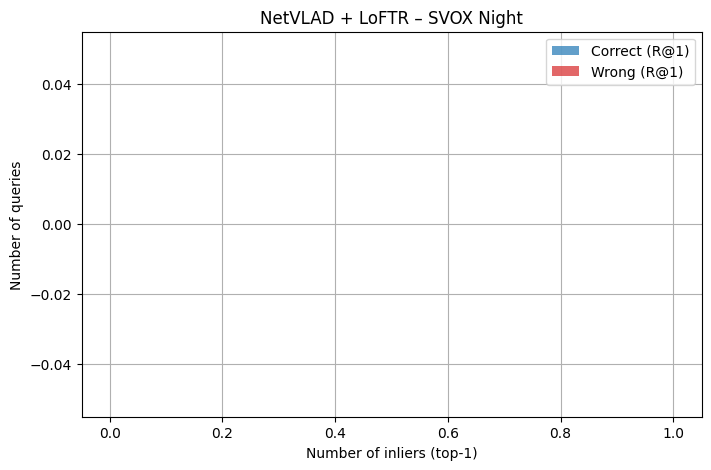

Correct queries:
 mean: nan
 median: nan
Wrong queries:
 mean: nan
 median: nan


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.hist(inliers_correct, bins=30, alpha=0.7, label="Correct (R@1)", color="tab:blue")
plt.hist(inliers_wrong, bins=30, alpha=0.7, label="Wrong (R@1)", color="tab:red")
plt.xlabel("Number of inliers (top-1)")
plt.ylabel("Number of queries")
plt.title("NetVLAD + LoFTR – SVOX Night")
plt.legend()
plt.grid(True)
plt.show()

print("Correct queries:")
print(" mean:", np.mean(inliers_correct))
print(" median:", np.median(inliers_correct))

print("Wrong queries:")
print(" mean:", np.mean(inliers_wrong))
print(" median:", np.median(inliers_wrong))

In [21]:
import numpy as np
import torch
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt

from util import get_list_distances_from_preds  # stesso usato da eval.py

POSITIVE_DIST_THRESHOLD = 25  # come nel testo: corretto se distanza GT <= 25m

def load_correct_and_inliers(preds_dir, inliers_dir, thr=25):
    txt_files = sorted(glob(str(Path(preds_dir) / "*.txt")), key=lambda x: int(Path(x).stem))

    y_correct = np.zeros(len(txt_files), dtype=np.int32)  # 1=correct, 0=wrong
    inliers = np.zeros(len(txt_files), dtype=np.float64)

    for i, txt in enumerate(txt_files):
        # corretto usando solo retrieval: guardo il top-1 nel file txt
        dists = get_list_distances_from_preds(txt)
        y_correct[i] = 1 if dists[0] <= thr else 0

        # inliers con la prima immagine retrieved
        torch_file = Path(inliers_dir) / Path(txt).name.replace(".txt", ".torch")
        r = torch.load(torch_file, map_location="cpu", weights_only=False)
        inliers[i] = r[0]["num_inliers"]

    return y_correct, inliers

def plot_histograms(y, inliers, title=""):
    correct = inliers[y == 1]
    wrong = inliers[y == 0]

    plt.figure(figsize=(7,4))
    bins = np.linspace(inliers.min(), inliers.max(), 40)
    plt.hist(wrong, bins=bins, alpha=0.6, label=f"Wrong (n={len(wrong)})",color='tab:red')
    plt.hist(correct, bins=bins, alpha=0.6, label=f"Correct (n={len(correct)})",color='tab:blue')
    plt.title(title)
    plt.xlabel("# inliers with top-1 retrieved image")
    plt.ylabel("# queries")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_boxplot(y, inliers, title=""):
    data = [inliers[y==0], inliers[y==1]]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=["Wrong", "Correct"], showfliers=True)
    plt.title(title)
    plt.ylabel("# inliers")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def threshold_curve(y, inliers, title=""):
    # sweep soglie sui valori interi di inliers
    taus = np.unique(inliers.astype(int))
    taus.sort()

    acc = []
    prec = []
    cov = []
    for t in taus:
        pred_correct = (inliers >= t).astype(int)  # regola: se inliers>=t predico "correct"
        accuracy = (pred_correct == y).mean()

        # precision quando predico "correct"
        if pred_correct.sum() > 0:
            precision = (y[pred_correct==1].sum() / pred_correct.sum())
        else:
            precision = np.nan

        acc.append(accuracy)
        prec.append(precision)
        cov.append(pred_correct.mean())  # quante query verrebbero “accettate come correct”

    # plot precision e coverage insieme (molto interpretabile)
    plt.figure(figsize=(7,4))
    plt.plot(taus, prec, label="Precision (among predicted correct)")
    plt.plot(taus, cov, label="Coverage (fraction predicted correct)")
    plt.title(title)
    plt.xlabel("Inliers threshold τ")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def point_biserial_corr(y, x):
    # y in {0,1}, x continua. Questa è una Pearson tra x e y.
    y = y.astype(np.float64)
    x = x.astype(np.float64)
    y = (y - y.mean()) / (y.std() + 1e-12)
    x = (x - x.mean()) / (x.std() + 1e-12)
    return float((x*y).mean())

# === scegli matcher ===
preds_dir = "logs/mixvpr_resnet50_svox_night/2026-01-21_17-12-03/preds"

inliers_dir_lg = "logs/mixvpr_resnet50_svox_night/2026-01-21_17-12-03/preds_superpoint-lg"
inliers_dir_loftr = "logs/mixvpr_resnet50_svox_night/2026-01-21_17-12-03/preds_loftr"

# LightGlue
y_lg, inl_lg = load_correct_and_inliers(preds_dir, inliers_dir_lg, thr=POSITIVE_DIST_THRESHOLD)
plot_histograms(y_lg, inl_lg, title="MixVPR R@1 correctness vs #inliers (LightGlue)")
#plot_boxplot(y_lg, inl_lg, title="MixVPR — #inliers distribution (LightGlue)")
#threshold_curve(y_lg, inl_lg, title="MixVPR — can we separate wrong/correct via inliers? (LightGlue)")
#print("Point-biserial correlation (LightGlue):", point_biserial_corr(y_lg, inl_lg))

# LoFTR (opzionale, stesso set di grafici)
y_loftr, inl_loftr = load_correct_and_inliers(preds_dir, inliers_dir_loftr, thr=POSITIVE_DIST_THRESHOLD)
plot_histograms(y_loftr, inl_loftr, title="MixVPR R@1 correctness vs #inliers (LoFTR)")
#plot_boxplot(y_loftr, inl_loftr, title="MixVPR — #inliers distribution (LoFTR)")
#threshold_curve(y_loftr, inl_loftr, title="MixVPR — can we separate wrong/correct via inliers? (LoFTR)")
#print("Point-biserial correlation (LoFTR):", point_biserial_corr(y_loftr, inl_loftr))


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 700x400 with 0 Axes>

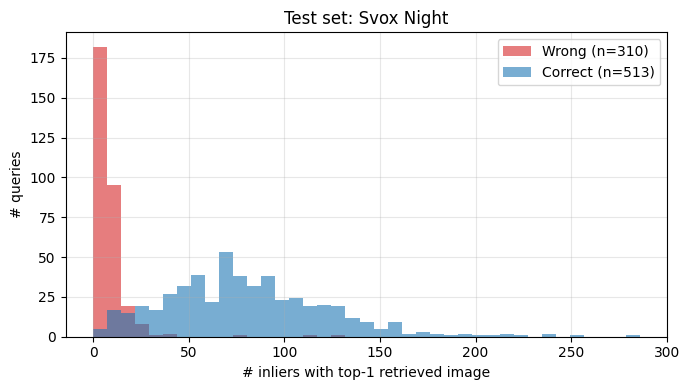

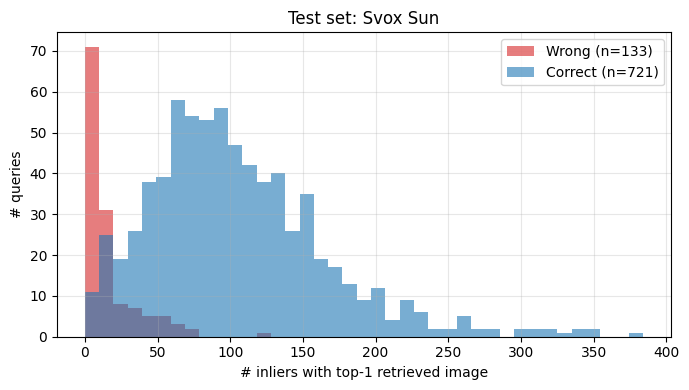

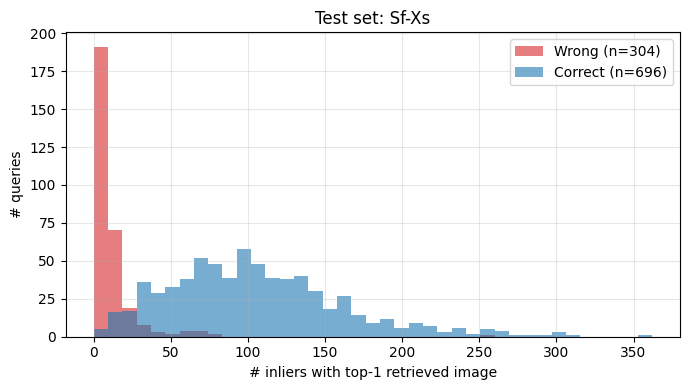

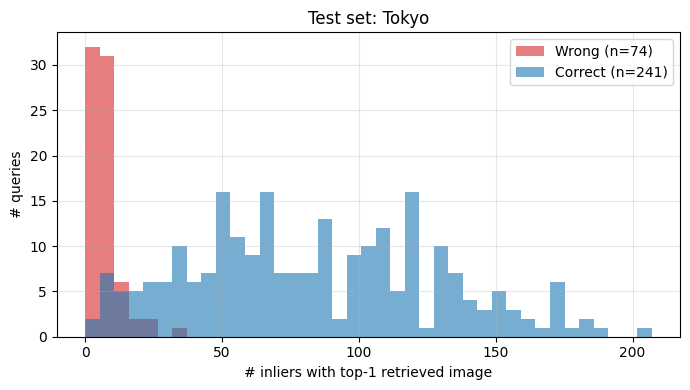

In [ ]:

# Svox Night - LightGlue
preds_dir = "test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds"
inliers_dir_lg = "test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds_superpoint-lg"

y_lg, inl_lg = load_correct_and_inliers(preds_dir, inliers_dir_lg, thr=POSITIVE_DIST_THRESHOLD)
plot_histograms(y_lg, inl_lg, title="Test set: Svox Night")


# Svox Sun - LightGlue
preds_dir = "test_logs/logs_svox_sun/mixvpr_resnet50_svox_sun/preds"
inliers_dir_lg = "test_logs/logs_svox_sun/mixvpr_resnet50_svox_sun/preds_superpoint-lg"

y_lg, inl_lg = load_correct_and_inliers(preds_dir, inliers_dir_lg, thr=POSITIVE_DIST_THRESHOLD)
plot_histograms(y_lg, inl_lg, title="Test set: Svox Sun")


# Sf-Xs - LightGlue
preds_dir = "test_logs/logs_sf_xs/mixvpr_resnet50_sf_xs/preds"
inliers_dir_lg = "test_logs/logs_sf_xs/mixvpr_resnet50_sf_xs/preds_superpoint-lg"

y_lg, inl_lg = load_correct_and_inliers(preds_dir, inliers_dir_lg, thr=POSITIVE_DIST_THRESHOLD)
plot_histograms(y_lg, inl_lg, title="Test set: Sf-Xs")



# Tokyo - LightGlue
preds_dir = "test_logs/logs_tokyo_xs/mixvpr_resnet50_tokyo_xs/preds"
inliers_dir_lg = "test_logs/logs_tokyo_xs/mixvpr_resnet50_tokyo_xs/preds_superpoint-lg"

y_lg, inl_lg = load_correct_and_inliers(preds_dir, inliers_dir_lg, thr=POSITIVE_DIST_THRESHOLD)
plot_histograms(y_lg, inl_lg, title="Test set: Tokyo")

Caricamento SVOX Night...
Caricamento SVOX Sun...
Caricamento SF-XS...
Caricamento Tokyo-XS...


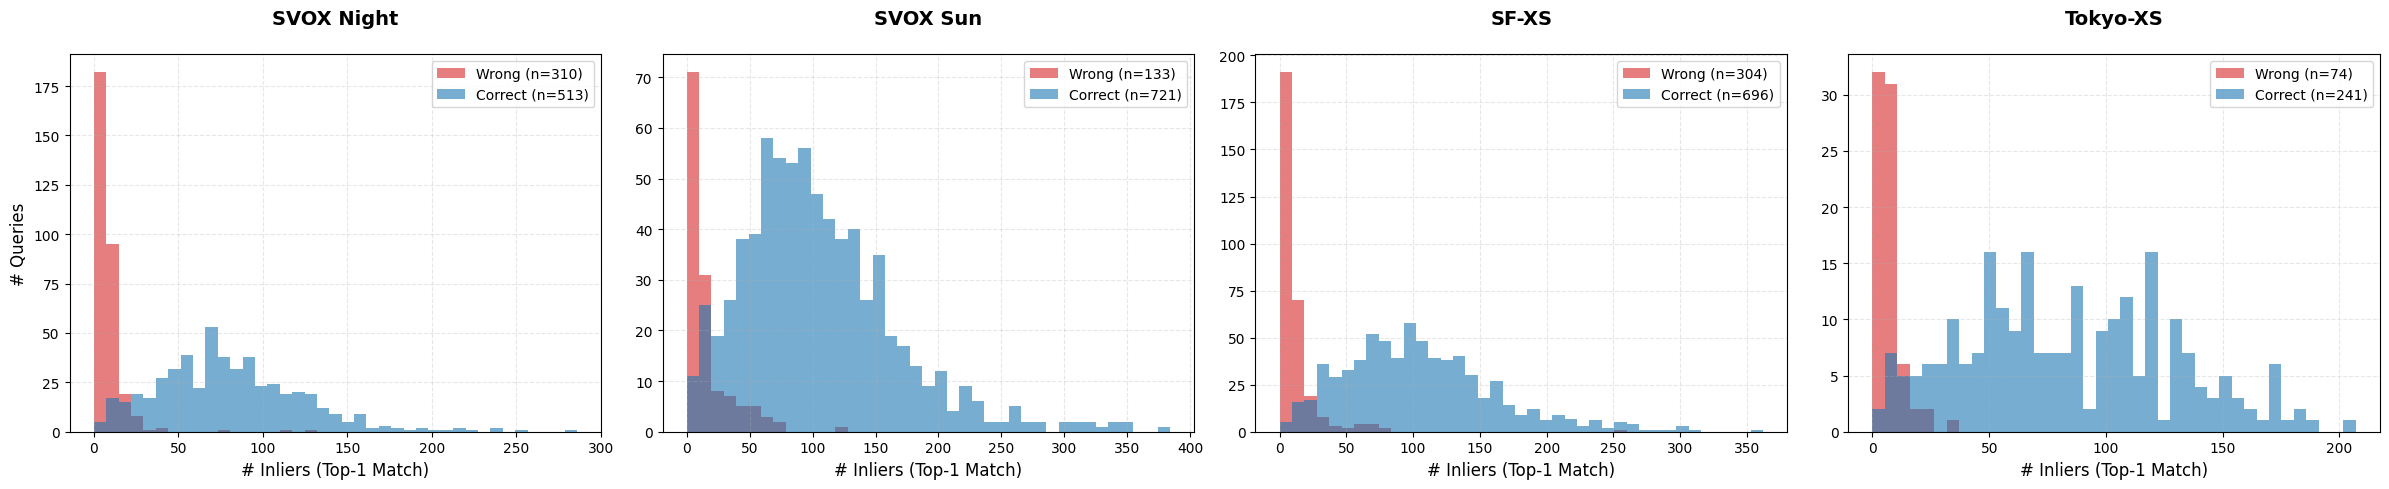

In [51]:
import numpy as np
import torch
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt

# Assicurati che util.py sia importabile
import sys, os
sys.path.append(os.getcwd())
from util import get_list_distances_from_preds

POSITIVE_DIST_THRESHOLD = 25

# --- FUNZIONE CARICAMENTO DATI ---
def load_correct_and_inliers(preds_dir, inliers_dir, thr=25):
    txt_files = sorted(glob(str(Path(preds_dir) / "*.txt")), key=lambda x: int(Path(x).stem))
    

    y_correct = np.zeros(len(txt_files), dtype=np.int32)
    inliers = np.zeros(len(txt_files), dtype=np.float64)

    for i, txt in enumerate(txt_files):
        # 1. Ground Truth
        dists = get_list_distances_from_preds(txt)
        y_correct[i] = 1 if dists[0] <= thr else 0

        # 2. Inliers
        torch_file = Path(inliers_dir) / Path(txt).name.replace(".txt", ".torch")
        if torch_file.exists():
            r = torch.load(torch_file, map_location="cpu", weights_only=False)
            if len(r) > 0: inliers[i] = r[0]["num_inliers"]
        else:
            inliers[i] = 0
            
    return y_correct, inliers

# --- CONFIGURAZIONE DATASET ---
datasets_config = [
    {
        "name": "SVOX Night",
        "preds": "test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds",
        "inliers": "test_logs/logs_svox_night/mixvpr_resnet50_svox_night/preds_superpoint-lg"
    },
    {
        "name": "SVOX Sun",
        "preds": "test_logs/logs_svox_sun/mixvpr_resnet50_svox_sun/preds",
        "inliers": "test_logs/logs_svox_sun/mixvpr_resnet50_svox_sun/preds_superpoint-lg"
    },
    {
        "name": "SF-XS",
        "preds": "test_logs/logs_sf_xs/mixvpr_resnet50_sf_xs/preds",
        "inliers": "test_logs/logs_sf_xs/mixvpr_resnet50_sf_xs/preds_superpoint-lg"
    },
    {
        "name": "Tokyo-XS",
        "preds": "test_logs/logs_tokyo_xs/mixvpr_resnet50_tokyo_xs/preds",
        "inliers": "test_logs/logs_tokyo_xs/mixvpr_resnet50_tokyo_xs/preds_superpoint-lg"
    }
]

# --- PLOTTING 1x4 ---
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=False) # sharey=False perché il n. di query varia molto


for i, config in enumerate(datasets_config):
    ax = axes[i]
    print(f"Caricamento {config['name']}...")
    
    # Carica Dati
    y, inliers = load_correct_and_inliers(config['preds'], config['inliers'], thr=POSITIVE_DIST_THRESHOLD)
    
    if len(y) == 0: continue


    # Dividi Correct/Wrong
    correct = inliers[y == 1]
    wrong = inliers[y == 0]

    # Calcola bin comuni per estetica
    min_val = inliers.min() if len(inliers) > 0 else 0
    max_val = inliers.max() if len(inliers) > 0 else 100
    bins = np.linspace(min_val, max_val, 40)

    # Istogramma
    ax.hist(wrong, bins=bins, alpha=0.6, color='tab:red', label=f"Wrong (n={len(wrong)})")
    ax.hist(correct, bins=bins, alpha=0.6, color='tab:blue', label=f"Correct (n={len(correct)})")
    
    # Decorazioni
    ax.set_title(f"{config['name']}\n", fontsize=14, fontweight='bold')
    ax.set_xlabel("# Inliers (Top-1 Match)", fontsize=12)
    if i == 0: ax.set_ylabel("# Queries", fontsize=12)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Grafico salvato come teaser_uncertainty.svg


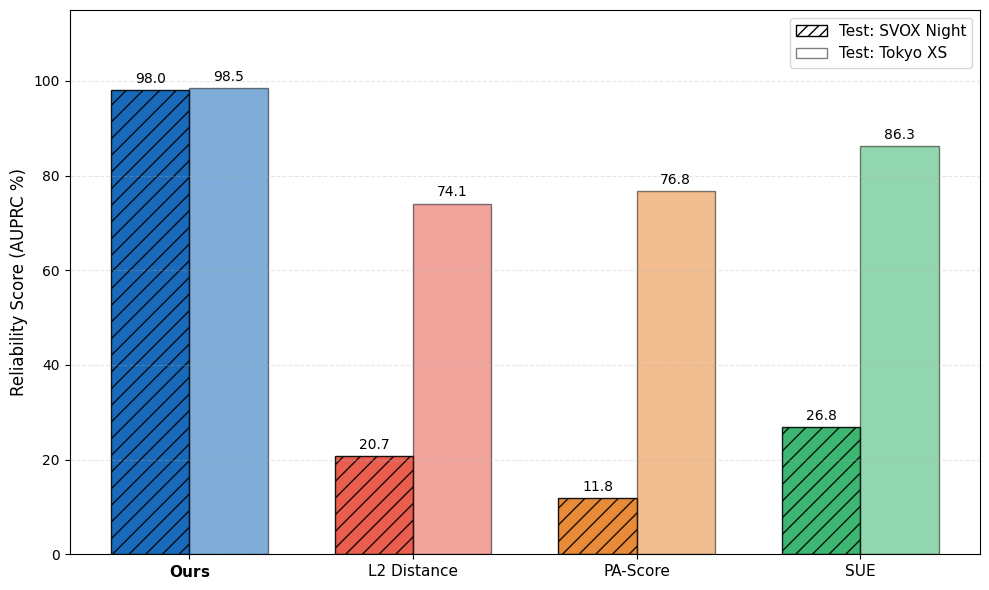

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_vertical_baselines_fixed():
    # --- DATI ---
    night_scores = [98.0, 20.7, 11.8, 26.8] 
    tokyo_scores = [98.5, 74.1, 76.8, 86.3] 
    methods = ['Ours', 'L2 Distance', 'PA-Score', 'SUE']
    colors = ["#005ab3", '#e74c3c', '#e67e22', '#27ae60'] 

    # --- PLOT ---
    x = np.arange(len(methods))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, night_scores, width, color=colors, alpha=0.9, hatch='//', edgecolor='black')
    rects2 = ax.bar(x + width/2, tokyo_scores, width, color=colors, alpha=0.5, edgecolor='black')

    # Legenda Custom
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', hatch='///', label='Test: SVOX Night'),
        Patch(facecolor='white', edgecolor='black', alpha=0.5, label='Test: Tokyo XS')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

    # Decorazioni
    ax.set_ylabel('Reliability Score (AUPRC %)', fontsize=12)
    ax.set_xticks(x)
    labels = [r"$\bf{Ours}$" if m == "Ours" else m for m in methods]
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylim(0, 115)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Valori
    ax.bar_label(rects1, padding=3, fmt='%.1f', fontsize=10)
    ax.bar_label(rects2, padding=3, fmt='%.1f', fontsize=10)

    plt.tight_layout()
    
    # --- SALVATAGGIO SVG ---
    # Salva nella cartella corrente. Puoi cambiare il nome.
    plt.savefig("teaser_uncertainty.svg", format='svg', bbox_inches='tight')
    print("Grafico salvato come teaser_uncertainty.svg")
    
    plt.show()

plot_vertical_baselines_fixed()